# This code uses the new discrete code

In [128]:
import os
import sys
import collections
import tensorflow as tf
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
a = os.path.join(module_path, "strands_qsr_lib\qsr_lib\src3")

sys.path.append(a)

## PLOTTING 
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
import plotting


### IMPORT FROM CURRENT PROJECT
import progress_learner
import config
import project
from project import Project

### RL module
from rl import action_learner, action_learner_search, value_estimator
from rl import block_movement_env
from rl import discrete_value_estimator as  dve
from rl import discrete_action_learner as dal


### RELOAD modules here
reload(config)
reload(value_estimator)
reload(config)
reload(block_movement_env)
reload(action_learner_search)
reload(progress_learner)
reload(dal)
reload(dve)


### AUXILIARY CODE
discretized_space = [0.18, 0.36, 0.72]


def action_policy ( state, policy_estimator, no_of_actions, verbose, session ):
    return dal.epsilon_greedy_action_2( state, policy_estimator, uniform_space, no_of_actions = no_of_actions, verbose= verbose,
                                       session = session, epsilon_1 = 0.6, epsilon_2 = 0 )


### MAIN CODE
tf.reset_default_graph()

c = config.Config()
c.num_episodes = 10

global_step = tf.Variable(0, name="global_step", trainable=False)


policy_est = dve.DiscretePolicyEstimator(c)
value_est = value_estimator.ValueEstimator(c)

sess =  tf.Session()

sess.run(tf.global_variables_initializer())

projects = {}
progress_estimators = {}

# action_types = ["SlideToward", "SlideAway", "SlideNext", "SlidePast", "SlideAround"]
action_types = ["SlideAround"]

for project_name in action_types:
    print ('========================================================')
    print ('Load for action type = ' + project_name)
    p_name = project_name.lower() + "_project.proj"

    projects[project_name] = project.Project.load('../' + p_name)

    with tf.variable_scope("model") as scope:
        print('-------- Load progress model ---------')
        progress_estimators[project_name] = progress_learner.EventProgressEstimator(is_training=True, name = projects[project_name].name, config = c)  

# Print out all variables that would be restored
for variable in tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model'):
    print (variable.name)

for project_name in action_types:
    saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='model/' + project_name))

    saver.restore(sess, '../progress_' + project_name + '.mod.1')

D:\git\learn-to-perform\rl\block_movement_env.py:8: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "C:\Anaconda3\envs\tensorflow\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Anaconda3\envs\tensorflow\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Anaconda3\envs\tensorflow\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\kernelapp.py", line 478, in start
    self.io_loop.start()
  File "C:\Anaconda3

Load for action type = SlideAround
-------- Load progress model ---------
self.inputs.shape = (?, 20, 200)  after linear layer
output.shape = (30, 200) after LSTM
self.output.shape = (30,) after linear
self._targets.shape = (?,) 
model/SlideAround/Variable:0
model/SlideAround/linear/weight:0
model/SlideAround/linear/bias:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0
model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0
model/SlideAround/output_linear/weight:0
model/SlideAround/output_linear/bias:0
model/SlideAround/beta1_power:0
model/SlideAround/beta2_power:0
model/SlideAround/model/SlideAround/linear/weight/Adam:0
model/SlideAround/model/SlideAround/linear/weight/Adam_1:0
model/SlideAround/model/SlideAround/linear/bias/Adam:0
model/SlideAround/model/SlideAround/linear/bias/Adam_1:0
model/SlideAround/model/SlideAround/lstm/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel/Adam:0
model/SlideAround/model/SlideAround/lstm/rnn/multi_rnn_cell/

In [134]:
c.num_episodes = 100
action_ln = dal.DiscreteActionLearner(c, projects['SlideAround'], progress_estimators['SlideAround'], 
                               policy_est, value_est, session = sess, limit_step = 10)

past_envs, stats = action_ln.policy_learn(action_policy, breadth = 2, verbose = True,
                                          choice = 'ACTOR_CRITIC', default = True)

(array([-0.05636576,  0.11417106,  0.22899547], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 2. -3.  2.]
 [ 2.  1.  4.]]
(array([-0.05636576,  0.11417106,  0.22899547], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([ 0.4691826 , -0.55894334,  1.38539816]), 0.39290520548820496)
action = (array([-0.03899562,  0.18385871,  0.6       ]), -0.0)
best reward = 0.39
best_action = (array([ 0.4691826 , -0.55894334,  1.38539816]), 0.39290520548820496, False)
Step 0 @ Episode 1/100 (0.39290520548820496)
td_target = 0.44, predicted_target = 0.19, advantage = 0.25
(array([-0.02305647,  0.15579778,  0.18756258], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.02305647  0.15579778  0.18756258]
 [-3.         -2.          1.        ]]
(array([-0.02305647,  0.15579778,  0.18756258], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([-0.62545115, -0.87163639,  0.99269908]), 0.39931902)

action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, False)
Step 1 @ Episode 4/100 (0.04612691327929497)
td_target = 0.04, predicted_target = 0.04, advantage = 0.00
(array([-0.01685302,  0.15459701,  0.20833117], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.01685302  0.15459701  0.20833117]
 [ 3.          1.          0.        ]]
(array([-0.01685302,  0.15459701,  0.20833117], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([0.2581252, 0.38713  , 0.6      ]), 0.7002428)
best reward = 0.70
best_action = (array([0.2581252, 0.38713  , 0.6      ]), 0.7002428, False)
Step 2 @ Episode 4/100 (0.746369730681181)
td_target = 0.64, predicted_target = 0.04, advantage = 0.60
(array([-0.00383059,  0.17237774,  0.20258965], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.00383059  0.17237774  0.2025896

action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, True)
Step 3 @ Episode 7/100 (0.5913658142089844)
td_target = 0.01, predicted_target = 0.01, advantage = 0.00
(array([-0.03428906,  0.13628955,  0.2603906 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.03428906  0.13628955  0.26039061]
 [-3.         -3.          1.        ]]
(array([-0.03428906,  0.13628955,  0.2603906 ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.42217986, -1.16875721,  0.99269908]), -0.0)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, False)
Step 0 @ Episode 8/100 (0.04612691327929497)
td_target = 0.09, predicted_target = 0.19, advantage = -0.10
(array([0.00372898, 0.16345555, 0.23340806], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 0.

action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, False)
Step 1 @ Episode 11/100 (0.04612691327929497)
td_target = 0.05, predicted_target = 0.05, advantage = -0.00
(array([-0.01017991,  0.14744626,  0.2517591 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.01017991  0.14744626  0.25175911]
 [-0.01017991  0.14744626  0.25175911]]
(array([-0.01017991,  0.14744626,  0.2517591 ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, False)
Step 2 @ Episode 11/100 (0.04612691327929497)
td_target = 0.05, predicted_target = 0.05, advantage = -0.00
(array([-0.01053227,  0.1472906 ,  0.25206253], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.01053227  0.1472906   0.2

action = (array([-0.48467686, -0.12104822,  0.6       ]), -0.07899517)
best reward = -0.08
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), -0.07899517, True)
Step 3 @ Episode 14/100 (0.3787035755813122)
td_target = -0.03, predicted_target = 0.02, advantage = -0.05
(array([-0.06253649,  0.13160557,  0.2821054 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.06253649  0.13160557  0.28210539]
 [-3.          2.          3.        ]]
(array([-0.06253649,  0.13160557,  0.2821054 ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-1.03199373, -0.27739475,  0.20730092]), -0.0)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, False)
Step 0 @ Episode 15/100 (0.04612691327929497)
td_target = 0.09, predicted_target = 0.18, advantage = -0.09
(array([-0.01727144,  0.1571964 ,  0.26245493], dtype=float32), array([1., 1., 1.

best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, False)
Step 1 @ Episode 18/100 (0.04612691327929497)
td_target = 0.05, predicted_target = 0.05, advantage = -0.00
(array([-0.0416805 ,  0.19455668,  0.2966818 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.0416805   0.19455668  0.29668179]
 [-0.0416805   0.19455668  0.29668179]]
(array([-0.0416805 ,  0.19455668,  0.2966818 ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, False)
Step 2 @ Episode 18/100 (0.04612691327929497)
td_target = 0.05, predicted_target = 0.05, advantage = -0.00
(array([-0.04394748,  0.196174  ,  0.29793388], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.04394748  0.196174    0.29793388]
 [-0.04394748  0.196174    0.29793388]]
(array([-0.04394748,  0.196174  ,

best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, True)
Step 3 @ Episode 21/100 (0.04612691327929497)
td_target = 0.05, predicted_target = 0.05, advantage = -0.00
(array([-0.08678871,  0.15151688,  0.33116716], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.08678871  0.15151688  0.33116716]
 [ 1.         -2.          0.        ]]
(array([-0.08678871,  0.15151688,  0.33116716], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([ 0.1173509 , -0.36345817,  0.6       ]), 0.006944357417523861)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, False)
Step 0 @ Episode 22/100 (0.04612691327929497)
td_target = 0.10, predicted_target = 0.19, advantage = -0.09
(array([-0.0605469 ,  0.1881848 ,  0.31726742], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.0605469   0.1881848   0.31726742]
 [-0.0

action = (array([0.46139649, 0.09000918, 0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, False)
Step 1 @ Episode 25/100 (0.04612691327929497)
td_target = 0.06, predicted_target = 0.06, advantage = -0.00
(array([-0.05916195,  0.16428559,  0.33975744], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.05916195  0.16428559  0.33975744]
 [-0.05916195  0.16428559  0.33975744]]
(array([-0.05916195,  0.16428559,  0.33975744], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, False)
Step 2 @ Episode 25/100 (0.04612691327929497)
td_target = 0.06, predicted_target = 0.06, advantage = -0.00
(array([-0.05911919,  0.16366474,  0.34060872], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.05911919  0.16366474  0.3406

action = (array([-0.48467686, -0.12104822,  0.6       ]), -0.5193965)
best reward = -0.52
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), -0.5193965, True)
Step 3 @ Episode 28/100 (0.06923754140734673)
td_target = -0.45, predicted_target = -0.02, advantage = -0.43
(array([-0.07868732,  0.12074454,  0.37240094], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-1.  3.  2.]
 [-3.  3.  2.]]
(array([-0.07868732,  0.12074454,  0.37240094], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.78958379,  0.32463301,  1.38539816]), 0.7695369124412537)
action = (array([-1.23526502,  0.01972607,  1.38539816]), -0.0)
best reward = 0.77
best_action = (array([-0.78958379,  0.32463301,  1.38539816]), 0.7695369124412537, False)
Step 0 @ Episode 29/100 (0.7695369124412537)
td_target = 0.85, predicted_target = 0.22, advantage = 0.63
(array([-0.02062529,  0.1428772 ,  0.28679943], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.02062529  0.14287721  0.2867

td_target = 0.06, predicted_target = 0.06, advantage = 0.00
(array([-0.07564208,  0.16336158,  0.37718806], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.07564208  0.16336158  0.37718806]
 [-3.         -2.          1.        ]]
(array([-0.07564208,  0.16336158,  0.37718806], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([-0.62545115, -0.87163639,  0.99269908]), -0.03968215)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, False)
Step 2 @ Episode 32/100 (0.04612691327929497)
td_target = 0.06, predicted_target = 0.06, advantage = 0.00
(array([-0.0762356,  0.1638201,  0.377696 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.0762356   0.1638201   0.37769601]
 [-0.0762356   0.1638201   0.37769601]]
(array([-0.0762356,  0.1638201,  0.377696 ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       

action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, True)
Step 3 @ Episode 35/100 (0.04612691327929497)
td_target = 0.06, predicted_target = 0.06, advantage = 0.00
(array([-0.10482431,  0.1426313 ,  0.40960905], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.10482431  0.14263131  0.40960905]
 [-2.          2.          4.        ]]
(array([-0.10482431,  0.1426313 ,  0.40960905], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.73487291, -0.07412346,  0.6       ]), 0.42685702443122864)
best reward = 0.43
best_action = (array([-0.73487291, -0.07412346,  0.6       ]), 0.42685702443122864, False)
Step 0 @ Episode 36/100 (0.42685702443122864)
td_target = 0.50, predicted_target = 0.24, advantage = 0.26
(array([-0.06879394,  0.19261698,  0.38972366], dtype=float32), array([1., 1., 1.], d

action = (array([-0.7270868 , -0.72307598,  0.6       ]), 0.3924559)
action = (array([-0.03899562,  0.18385871,  1.38539816]), 0.18072186)
best reward = 0.39
best_action = (array([-0.7270868 , -0.72307598,  0.6       ]), 0.3924559, False)
Step 1 @ Episode 39/100 (0.40985560417175293)
td_target = 0.57, predicted_target = -0.00, advantage = 0.58
(array([-0.11872829,  0.14246288,  0.45640135], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.11872829  0.14246288  0.45640135]
 [-0.11872829  0.14246288  0.45640135]]
(array([-0.11872829,  0.14246288,  0.45640135], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), -0.36691114)
action = (array([-0.48467686, -0.12104822,  0.6       ]), -0.36691114)
best reward = -0.37
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), -0.36691114, False)
Step 2 @ Episode 39/100 (0.04294446110725403)
td_target = -0.34, predicted_target = 0.18, advantage = -0.52
(array([-0.04203798,  

(array([-0.10041921,  0.14821692,  0.43255553], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.10041921  0.14821692  0.43255553]
 [-2.         -3.          0.        ]]
(array([-0.10041921,  0.14821692,  0.43255553], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.12505904, -0.96548592,  0.6       ]), -0.0)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, False)
Step 0 @ Episode 43/100 (0.04612691327929497)
td_target = 0.10, predicted_target = 0.25, advantage = -0.15
(array([-0.05696753,  0.18955372,  0.39345232], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.05696753  0.18955372  0.39345232]
 [-3.          2.          4.        ]]
(array([-0.05696753,  0.18955372,  0.39345232], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([-1

action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.23403144)
action = (array([-0.18755603,  0.08222307,  0.20730092]), -0.23846132)
best reward = -0.23
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.23403144, False)
Step 1 @ Episode 46/100 (0.5935725569725037)
td_target = -0.22, predicted_target = -0.05, advantage = -0.17
(array([-0.03535072,  0.17581037,  0.38451573], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.03535072  0.17581037  0.38451573]
 [-0.03535072  0.17581037  0.38451573]]
(array([-0.03535072,  0.17581037,  0.38451573], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), -0.21543676)
action = (array([-0.48467686, -0.12104822,  0.6       ]), -0.21543676)
best reward = -0.22
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), -0.21543676, False)
Step 2 @ Episode 46/100 (0.3781358003616333)
td_target = -0.16, predicted_target = 0.02, advantage = -0.18
(array([-0.06343

action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.25266147)
best reward = -0.25
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.25266147, True)
Step 3 @ Episode 49/100 (0.5728916637599468)
td_target = -0.26, predicted_target = -0.05, advantage = -0.20
(array([-0.10278653,  0.1824617 ,  0.4424887 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.10278653  0.18246169  0.4424887 ]
 [ 2.          1.          0.        ]]
(array([-0.10278653,  0.1824617 ,  0.4424887 ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.03899562,  0.18385871,  0.6       ]), -0.0)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, False)
Step 0 @ Episode 50/100 (0.04612691327929497)
td_target = 0.10, predicted_target = 0.25, advantage = -0.16
(array([-0.05507689,  0.21703333,  0.3974804 ], dtype=float32), array([1., 1., 1

action = (array([-0.5863125 ,  0.02751219,  1.38539816]), 0.028800875)
best reward = 0.03
best_action = (array([-0.5863125 ,  0.02751219,  1.38539816]), 0.028800875, False)
Step 1 @ Episode 53/100 (0.20850639045238495)
td_target = 0.11, predicted_target = 0.23, advantage = -0.12
(array([-0.03642797,  0.20703547,  0.3499287 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.03642797  0.20703547  0.34992871]
 [-0.03642797  0.20703547  0.34992871]]
(array([-0.03642797,  0.20703547,  0.3499287 ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04605533)
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04605533)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04605533, False)
Step 2 @ Episode 53/100 (0.25456172227859497)
td_target = 0.14, predicted_target = 0.08, advantage = 0.05
(array([-0.06148757,  0.2176834 ,  0.42886308], dtype=float32), array([1., 1., 1.], dtype=floa

best_action = (array([-0.63323727, -0.22268387,  0.6       ]), -0.12874055, True)
Step 3 @ Episode 56/100 (0.21247771382331848)
td_target = -0.03, predicted_target = 0.09, advantage = -0.12
(array([-0.0959679 ,  0.19716951,  0.44620895], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.0959679   0.19716951  0.44620895]
 [-1.         -1.          3.        ]]
(array([-0.0959679 ,  0.19716951,  0.44620895], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.28140557, -0.41816905,  0.20730092]), 0.007108184043318033)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, False)
Step 0 @ Episode 57/100 (0.04612691327929497)
td_target = 0.10, predicted_target = 0.25, advantage = -0.15
(array([-0.0476847 ,  0.23082373,  0.40322945], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.0476847   0.23082373  0.40322945]
 [-3.         -3

action = (array([ 0.56303213, -0.05855123,  1.38539816]), 0.11396293)
action = (array([-0.03899562,  0.18385871,  0.99269908]), 0.1805538)
best reward = 0.18
best_action = (array([-0.03899562,  0.18385871,  0.99269908]), 0.1805538, False)
Step 1 @ Episode 60/100 (0.1874981513246894)
td_target = 0.14, predicted_target = 0.06, advantage = 0.08
(array([0.01383048, 0.21492958, 0.3435561 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[0.01383048 0.21492958 0.34355611]
 [0.01383048 0.21492958 0.34355611]]
(array([0.01383048, 0.21492958, 0.3435561 ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.08811659)
action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.08811659)
best reward = -0.09
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.08811659, False)
Step 2 @ Episode 60/100 (0.09938155766576529)
td_target = -0.08, predicted_target = -0.04, advantage = -0.03
(array([-0.01467049,  0.22325225,  

(array([-0.03965757,  0.24016632,  0.41566393], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-2. -1.  2.]
 [-3. -3.  3.]]
(array([-0.03965757,  0.24016632,  0.41566393], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.42996598, -0.51980469,  1.38539816]), 0.08579895)
best reward = 0.09
best_action = (array([-0.42996598, -0.51980469,  1.38539816]), 0.08579895, True)
Step 3 @ Episode 63/100 (0.18691517412662506)
td_target = 0.29, predicted_target = 0.05, advantage = 0.23
(array([-0.08378413,  0.20529947,  0.46157262], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 1.  2.  4.]
 [ 2. -1.  0.]]
(array([-0.08378413,  0.20529947,  0.46157262], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.28919168,  0.23078348,  0.6       ]), 0.6244196891784668)
action = (array([ 0.16427567, -0.11326211,  0.6       ]), 0.003979254513978958)
best reward = 0.62
best_action = (array([-0.28919168,  0.23078348,  0.6       ]), 0.6244196891784668, Fa

best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, False)
Step 0 @ Episode 67/100 (0.04612691327929497)
td_target = 0.10, predicted_target = 0.25, advantage = -0.15
(array([-0.02990863,  0.2422727 ,  0.42053568], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.02990863  0.2422727   0.42053568]
 [ 2.         -1.          0.        ]]
(array([-0.02990863,  0.2422727 ,  0.42053568], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([ 0.16427567, -0.11326211,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, False)
Step 1 @ Episode 67/100 (0.04612691327929497)
td_target = 0.06, predicted_target = 0.05, advantage = 0.00
(array([-0.02932533,  0.24260575,  0.42060998], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 1. -3.  0.]
 [ 1. -1.  3.]]
(array([-0.02932533,  0.24260575,  0.42060998], dtype=float32), ar

action = (array([-0.14063127,  0.33241912,  0.6       ]), 0.6301148)
best reward = 0.63
best_action = (array([-0.14063127,  0.33241912,  0.6       ]), 0.6301148, False)
Step 2 @ Episode 70/100 (0.6830198764801025)
td_target = 0.54, predicted_target = 0.05, advantage = 0.48
(array([0.04323696, 0.22315957, 0.32208845], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 0.04323696  0.22315957  0.32208845]
 [ 3.         -1.          3.        ]]
(array([0.04323696, 0.22315957, 0.32208845], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.10207242)
best reward = -0.10
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.10207242, True)
Step 3 @ Episode 70/100 (0.5809474587440491)
td_target = -0.07, predicted_target = -0.09, advantage = 0.02
(array([-0.06394758,  0.21326429,  0.46667045], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.06394758  0.21326429  0.46667045]
 [-0.06394758  0.21326429  0.46667

action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([ 0.02350137, -0.86385028,  0.6       ]), 0.40316689014434814)
best reward = 0.40
best_action = (array([ 0.02350137, -0.86385028,  0.6       ]), 0.40316689014434814, False)
Step 0 @ Episode 74/100 (0.40316689014434814)
td_target = 0.56, predicted_target = 0.25, advantage = 0.31
(array([-0.06352831,  0.23132956,  0.59890074], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.06352831  0.23132956  0.59890074]
 [ 3.         -3.          3.        ]]
(array([-0.06352831,  0.23132956,  0.59890074], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.99269908]), 0.17979312)
action = (array([ 0.76630342, -0.35567205,  0.20730092]), -0.20492043)
best reward = 0.18
best_action = (array([-0.48467686, -0.12104822,  0.99269908]), 0.17979312, False)
Step 1 @ Episode 74/100 (0.5829600095748901)
td_target = 0.25, predicted_target = 0.16, advantage = 0.09


(array([-0.01107126,  0.2550809 ,  0.41841325], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([-0.17976992, -0.56672946,  0.99269908]), -0.04273726)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, False)
Step 2 @ Episode 77/100 (0.04612691327929497)
td_target = 0.05, predicted_target = 0.05, advantage = -0.00
(array([-0.01115963,  0.2551294 ,  0.41845757], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.01115963  0.2551294   0.41845757]
 [-0.01115963  0.2551294   0.41845757]]
(array([-0.01115963,  0.2551294 ,  0.41845757], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, True)
Step 3 @ Episode 77/100 (0.04612691327929497)
td_target = 0.05, predicted_target = 0.05, advantage = -0.00
(array([-0.04954902,  0

(array([-0.04938774,  0.21918878,  0.46586964], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.04938774  0.21918878  0.46586964]
 [-0.04938774  0.21918878  0.46586964]]
(array([-0.04938774,  0.21918878,  0.46586964], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, False)
Step 0 @ Episode 81/100 (0.04612691327929497)
td_target = 0.10, predicted_target = 0.25, advantage = -0.15
(array([-0.0137847 ,  0.2554236 ,  0.42261252], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.0137847   0.25542361  0.42261252]
 [ 2.         -1.          2.        ]]
(array([-0.0137847 ,  0.2554236 ,  0.42261252], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
acti

action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0)
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0, False)
Step 2 @ Episode 84/100 (0.3876693546772003)
td_target = -0.00, predicted_target = -0.00, advantage = 0.00
(array([0.02141512, 0.20101489, 0.3317771 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[0.02141512 0.20101489 0.3317771 ]
 [3.         2.         2.        ]]
(array([0.02141512, 0.20101489, 0.3317771 ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0, True)
Step 3 @ Episode 84/100 (0.3876693546772003)
td_target = -0.00, predicted_target = -0.00, advantage = 0.00
(array([-0.04959605,  0.22747786,  0.46416393], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.04959605  0.22747786  0.46416393]
 [-0

(array([-0.04901683,  0.23530926,  0.46323928], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.04901683  0.23530926  0.46323928]
 [-0.04901683  0.23530926  0.46323928]]
(array([-0.04901683,  0.23530926,  0.46323928], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, False)
Step 0 @ Episode 88/100 (0.04612691327929497)
td_target = 0.10, predicted_target = 0.25, advantage = -0.15
(array([-0.01602783,  0.2694747 ,  0.42038193], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.01602783  0.26947469  0.42038193]
 [-1.          2.          3.        ]]
(array([-0.01602783,  0.2694747 ,  0.42038193], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
acti

action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.4765918403863907)
action = (array([-0.42996598, -0.51980469,  0.6       ]), -0.5563214868307114)
best reward = -0.48
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.4765918403863907, False)
Step 2 @ Episode 91/100 (0.23892758786678314)
td_target = -0.47, predicted_target = 0.02, advantage = -0.50
(array([0.00913696, 0.23107268, 0.3947455 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[ 0.00913696  0.23107268  0.3947455 ]
 [-2.          2.          2.        ]]
(array([0.00913696, 0.23107268, 0.3947455 ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0, True)
Step 3 @ Episode 91/100 (0.23892758786678314)
td_target = 0.00, predicted_target = 0.00, advantage = 0.00
(array([-0.05087127,  0.23989666,  0.46184033], dtype=float32), array([1., 1., 1.], dtyp

action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497)
action = (array([-0.62545115, -0.87163639,  1.38539816]), 0.009560948237776756)
best reward = 0.05
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.04612691327929497, False)
Step 0 @ Episode 95/100 (0.04612691327929497)
td_target = 0.10, predicted_target = 0.25, advantage = -0.15
(array([-0.01767684,  0.28223643,  0.4178885 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.01767684  0.28223643  0.41788849]
 [-0.01767684  0.28223643  0.41788849]]
(array([-0.01767684,  0.28223643,  0.4178885 ], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.48467686, -0.12104822,  0.6       ]), 0.0, False)
Step 1 @ Episode 95/100 (0.04612691327929497)
td_target = 0.05, predicted_target = 0.05, advantage = 0.00
(array([-0.01747792

action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.23986128)
action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.23986128)
best reward = -0.24
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), -0.23986128, False)
Step 2 @ Episode 98/100 (0.3430987298488617)
td_target = -0.27, predicted_target = 0.06, advantage = -0.33
(array([0.02824364, 0.27459896, 0.40972874], dtype=float32), array([1., 1., 1.], dtype=float32))
[[0.02824364 0.27459896 0.40972874]
 [0.02824364 0.27459896 0.40972874]]
(array([0.02824364, 0.27459896, 0.40972874], dtype=float32), array([1., 1., 1.], dtype=float32))
action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0)
best reward = 0.00
best_action = (array([-0.18755603,  0.08222307,  0.6       ]), 0.0, True)
Step 3 @ Episode 98/100 (0.3430987298488617)
td_target = -0.03, predicted_target = -0.03, advantage = 0.00
(array([-0.04905397,  0.2546794 ,  0.4596113 ], dtype=float32), array([1., 1., 1.], dtype=float32))
[[-0.04905397  0.2

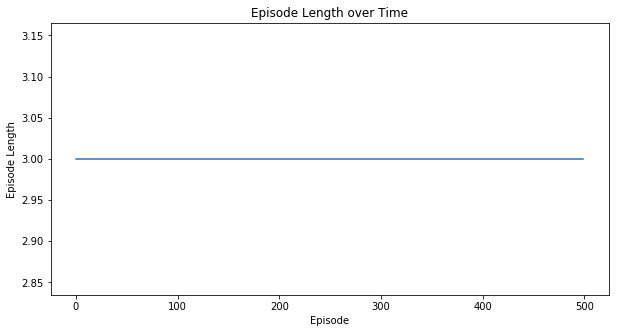

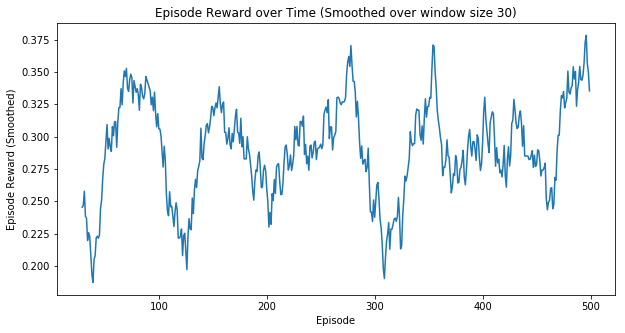

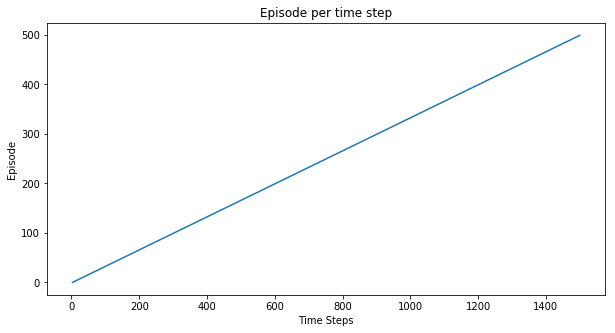

(<matplotlib.figure.Figure at 0x23e1da5f710>,
 <matplotlib.figure.Figure at 0x23e1134ccf8>)

In [119]:
plotting.plot_episode_stats(stats, smoothing_window=30)

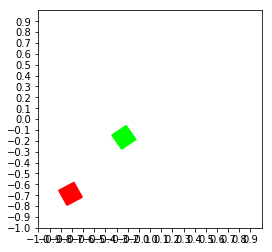

(array([-0.3365126 ,  0.00546155,  1.04197583]), array([1., 1., 1.], dtype=float32))
[-0.48467686 -0.12104822  0.6       ]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]]
Progress = 0.05; reward = 0.05


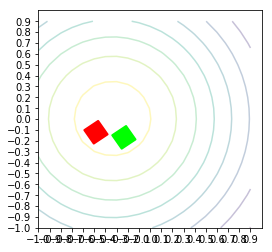

(array([-0.28817329,  0.04257815,  0.99804474]), array([1., 1., 1.], dtype=float32))
[-0.48467686 -0.12104822  0.6       ]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]]
Progress = 0.05; reward = 0.00


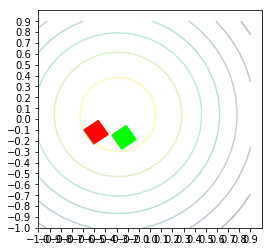

(array([-0.28773375,  0.0438173 ,  0.99813328]), array([1., 1., 1.], dtype=float32))
[-0.48467686 -0.12104822  0.6       ]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]]
Progress = 0.05; reward = 0.00


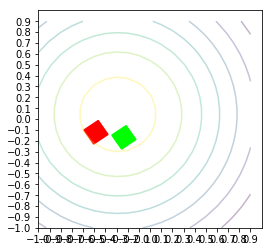

(array([-0.28733738,  0.04493476,  0.99821321]), array([1., 1., 1.], dtype=float32))
[-0.48467686 -0.12104822  0.6       ]
[[ 0.  0.  0.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0. -1. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0.  0.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [-1.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0. -1. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]
 [ 0.  0. -1.  0. -1.  0.  0.]]
Progress = 0.05; reward = 0.00


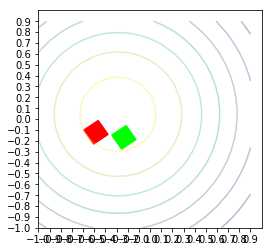

In [137]:
past_envs[47].env.replay(verbose = True)

In [96]:
np.random.choice(2)

0

In [97]:
[1, -1] [np.random.choice(2)]

-1